# WEB SCRAPING

Importamos paquetes necesarios


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

Obtenemos las URL de todas las páginas con noticias de la VIU

In [6]:
def obtener_enlaces(num_pag):
  j=0
  enlaces_noticias=[]
  enlaces_paginas=[]
  for j in range(0,num_pag):
    if j == 0:
      URL = "https://www.universidadviu.com/es/actualidad/noticias?buscar=&fecha=&field_shared_category_target_id=All&field_shared_tag_target_id=All"
    else:
      URL = "https://www.universidadviu.com/es/actualidad/noticias?buscar=&fecha=&field_shared_category_target_id=All&field_shared_tag_target_id=All&page="+str(j)
    enlaces_paginas.append(URL)
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    enlace_pagina=soup.find_all('div', class_="views-row")
    for i in range(len(enlace_pagina)):
      enlaces_noticias.append("https://www.universidadviu.com"+str(enlace_pagina[i].find("a").attrs["href"]))
  return enlaces_paginas, enlaces_noticias


In [7]:
enlaces_paginas, enlaces_noticias=obtener_enlaces(49)

Nos aseguramos de tener todas las páginas detectadas (actualmente la VIU presenta 49 paginas)

In [8]:
len(enlaces_paginas)

49

Del mismo modo, nos aseguramos de tener todas las noticias de la VIU detectadas (vemos que OK, pues hay 48 páginas con 16 noticias cada una, más la página 49 que solo tiene 2 páginas, por lo que 48x16+2=770 OK)

In [9]:
len(enlaces_noticias)

776

Vamos extrayendo el contenido de las diferentes noticias

In [14]:
def obtener_contenido(enlaces_noticias):
  contenidos=[]
  contador=0
  for i in enlaces_noticias:
    page = requests.get(i)
    soup = BeautifulSoup(page.content, "html.parser")
    if soup.find("script", type="application/ld+json")!=None:
      contenidos.append([json.loads(soup.find("script", type="application/ld+json").text)["@graph"][0]["articleBody"]])
      contador+=1
    print(contador)
  return contenidos




Cada contenido es una lista dentro de la lista "contenidos", de esta forma podemos acceder fácil al contenido y podemos mapearlo con la noticia en cuestión si fuera necesario.

In [16]:
len(contenidos)

776

Compruebo un contenido al azar

In [20]:
contenidos[701]

['\r\n\r\n\r\n\tMáster en Periodismo Multimedia y Máster en Producción y Dirección de Contenidos Audiovisuales son los primeros programas que surgen de esta colaboración\r\n\tLos dos programas universitarios ofrecen formación semipresencial con un claustro integrado por profesionales como Helena Resano o Vicente Vallés\r\n\r\n\r\n&nbsp;\r\n\r\nLa Universidad Internacional de Valencia –VIU y Atresmedia -el primer grupo audiovisual español- se unen para ofrecer la primera edición del Máster en Periodismo Multimedia y el Máster en Producción y Dirección de Contenidos Audiovisuales para el próximo mes de octubre.\r\n\r\nEstos nuevos programas de postgrado apuestan por un claustro formado por profesionales del sector de la comunicación que trabajan en la actualidad en programas del grupo de comunicación, como Helena Resano, presentadora de LaSexta Noticias, que será la directora del Máster en Periodismo Multimedia. Entre el profesorado también se encuentra Vicente Vallés, director y present

Como hemos dicho el contenido de cada noticias es una lista dentro de "contenidos", en este caso es una lista de longitud 1, luego para poder trabajar sobre el texto propiamente dicho del contenido, debemos poner [0].

In [18]:
contenidos[701][0]

'\r\n\r\n\r\n\tMáster en Periodismo Multimedia y Máster en Producción y Dirección de Contenidos Audiovisuales son los primeros programas que surgen de esta colaboración\r\n\tLos dos programas universitarios ofrecen formación semipresencial con un claustro integrado por profesionales como Helena Resano o Vicente Vallés\r\n\r\n\r\n&nbsp;\r\n\r\nLa Universidad Internacional de Valencia –VIU y Atresmedia -el primer grupo audiovisual español- se unen para ofrecer la primera edición del Máster en Periodismo Multimedia y el Máster en Producción y Dirección de Contenidos Audiovisuales para el próximo mes de octubre.\r\n\r\nEstos nuevos programas de postgrado apuestan por un claustro formado por profesionales del sector de la comunicación que trabajan en la actualidad en programas del grupo de comunicación, como Helena Resano, presentadora de LaSexta Noticias, que será la directora del Máster en Periodismo Multimedia. Entre el profesorado también se encuentra Vicente Vallés, director y presenta

Veamos el número de caracteres de una noticia al azar

In [22]:
len(contenidos[701][0])

3539

# PROCESAMIENTO

In [33]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
from gensim.corpora import Dictionary

In [24]:
def preprocesamiento(texto):
    """
    Función para realizar la limpieza de un texto dado.
    """
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    #Eliminamos otros espacios en blanco forzados en lenguaje HTML
    texto = re.sub(r'nbsp', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

In [25]:
for i in range(len(contenidos)):
  contenidos[i][0]=preprocesamiento(contenidos[i][0])


Veamos su resultado, sobre el contenido que mostramos con anterioridad (contenido noticia 0)

In [ ]:
contenidos[701][0]

In [27]:
len(contenidos[701][0])

3368

Los espacios ocasionados por el preprocesamiento no son importantes, pues el tokenizar en el paso a continuación desaparecerán.

In [28]:
tokenizer = ToktokTokenizer()
for i in range(len(contenidos)):
  contenidos[i][0]=tokenizer.tokenize(contenidos[i][0])


Veamos el resultado

In [ ]:
contenidos[701][0]

In [30]:
len(contenidos[701][0])

480

Ahora eliminamos aquellas palabras que no aportan significado y los dígitos que pueda haber en el contenido.

In [34]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("spanish"))

def filtro(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS
            and not token.isdigit()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
for i in range(len(contenidos)):
  contenidos[i][0]=filtro(contenidos[i][0])


Veamos el resultado

In [ ]:
contenidos[701][0]

In [38]:
len(contenidos[701][0])

275

Como vemos se ha reducido el número de palabras considerablemente tras el preprocesamiento y el filtro

Por último lematizamos las palabras, en busca de su raíz.

In [49]:
stemmer = SnowballStemmer("spanish")

def stemming(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

In [51]:
for i in range(len(contenidos)):
  contenidos[i][0]=stemming(contenidos[i][0])

Veamos el resultado

In [ ]:
contenidos[701][0]

El número de palabras tiene que seguir siendo el mismo

In [52]:
len(contenidos[701][0])

275

In [53]:
tokens=[]
for i in range(len(contenidos)):
   tokens.append(contenidos[i][0])

In [54]:
len(tokens)

776

In [55]:
contador=0
for i in range(len(tokens)): contador+=len(tokens[i])
print("Número de tokens", contador)


Número de tokens 388253


In [57]:
diccionario=Dictionary(tokens)

In [58]:
len(diccionario)

14273

Veamos los elementos del diccionario

In [ ]:
list (diccionario.items ())

In [65]:
diccionario.filter_extremes(no_below=2, no_above = 0.66)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 8007


A continuación creamos el corpus, de forma que tendremos en los documentos cada palabra indexada y con el recuento del número de veces que dicha palabra aparece en el documento.

In [66]:
# Creamos el corpus
corpus = [diccionario.doc2bow(contenidos[i][0]) for i in range(len(contenidos))]

In [67]:
len(corpus)

776

Veamos uno al azar

In [ ]:
corpus[701]




# MODELO LSA


In [73]:
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

In [72]:
def lsa_model(diccionario,corpus,num_topicos,palabras):
    # generate LSA model
    lsamodel = LsiModel(corpus, num_topics=num_topicos, id2word = diccionario)  # train model
    print(lsamodel.print_topics(num_topics=num_topicos, num_words=palabras))
    return lsamodel

In [ ]:
lsa_model(diccionario,corpus,10,8)

[(0, '0.210*"investig" + 0.176*"trabaj" + 0.172*"person" + 0.149*"educ" + 0.138*"profesional" + 0.133*"salud" + 0.129*"social" + 0.128*"hac"'), (1, '-0.449*"educ" + -0.242*"investig" + -0.226*"proyect" + 0.186*"person" + -0.173*"alumn" + -0.161*"docent" + -0.144*"premi" + 0.136*"mayor"'), (2, '0.555*"investig" + -0.382*"educ" + 0.264*"salud" + -0.176*"derech" + 0.153*"grup" + -0.150*"alumn" + 0.111*"trabaj" + -0.110*"aprendizaj"'), (3, '-0.342*"investig" + 0.324*"person" + 0.295*"salud" + -0.258*"derech" + 0.226*"mayor" + -0.224*"human" + 0.192*"educ" + 0.134*"psicolog"'), (4, '-0.326*"person" + -0.304*"investig" + -0.262*"mayor" + 0.259*"profesional" + 0.222*"salud" + -0.182*"grup" + -0.169*"educ" + -0.166*"social"'), (5, '-0.428*"derech" + -0.272*"human" + 0.205*"energ" + -0.177*"sanitari" + -0.167*"salud" + -0.162*"social" + -0.152*"profesional" + 0.150*"tecnolog"'), (6, '0.308*"mayor" + 0.281*"person" + -0.264*"trabaj" + -0.221*"educ" + 0.190*"radi" + -0.180*"violenci" + -0.172*"sa

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def valores_coherencia(diccionario, corpus, noticias, limit, start=2, step=2):
  valores_coherencia = []
  lista_modelos = []
  for numero_topicos in range(start, limit, step):
    model=LsiModel(corpus=corpus, id2word=diccionario, num_topics=numero_topicos,chunksize=800, random_seed=2, power_iters=10)
    lista_modelos.append(model)
    coherencemodel = CoherenceModel(model=model, texts=noticias, dictionary=diccionario,coherence='c_v')
    valores_coherencia.append(coherencemodel.get_coherence())
  return lista_modelos, valores_coherencia

In [ ]:
lista_modelos, valores_coherencia = valores_coherencia(diccionario,corpus,[contenidos[i][0] for i in range(len(contenidos))],16,4,1)

In [ ]:
for i in range(len(lista_modelos)):
  print("El modelo",lista_modelos[i],"tiene un valor de coherencia de",valores_coherencia[i])

El modelo LsiModel<num_terms=8300, num_topics=4, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.33653757385490657
El modelo LsiModel<num_terms=8300, num_topics=5, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.3493115767442331
El modelo LsiModel<num_terms=8300, num_topics=6, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.3882771901060262
El modelo LsiModel<num_terms=8300, num_topics=7, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.37347378411778315
El modelo LsiModel<num_terms=8300, num_topics=8, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.33512516769866096
El modelo LsiModel<num_terms=8300, num_topics=9, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.32316247694989114
El modelo LsiModel<num_terms=8300, num_topics=10, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.3414650940082128
El modelo LsiModel<num_terms=8300, num_topics=11, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.338

# MODELO PLSA


In [ ]:
!pip install plsa
from plsa import Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA
from plsa.corpus import Corpus
from plsa.preprocessors import remove_non_ascii,to_lower,remove_numbers,remove_tags,remove_punctuation,tokenize,RemoveStopwords,LemmatizeWords,remove_short_words

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pipeline = Pipeline(*DEFAULT_PIPELINE)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
corpus_PLSA=Corpus([contenidos[i][0] for i in range(len(contenidos))],pipeline)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LookupError: ignored

In [ ]:
plsa = PLSA(corpus_PLSA, 6, True)
result = plsa.fit()

In [ ]:
result = plsa.best_of(3)

In [ ]:
result.topic

array([0.18936769, 0.18283874, 0.16939623, 0.15852771, 0.15666072,
       0.14320891])

In [ ]:
result.word_given_topic

(('becas', 0.002903166433697998),
 ('ganadores', 0.002424897010600768),
 ('premio', 0.002295919751614748),
 ('bootcamp', 0.0022883099836056723),
 ('proyecto', 0.002252524373405982),
 ('premios', 0.0021318492034612425),
 ('quiero', 0.002032414769985307),
 ('beca', 0.0019430103360031817),
 ('proyectos', 0.001899634498016947),
 ('certamen', 0.0016702929209527282),
 ('leer', 0.001605522502174539),
 ('edici', 0.0015271319887390506),
 ('docente', 0.001479962429870072),
 ('ganador', 0.0013479712022349151),
 ('lara', 0.0012840127075847336),
 ('profesores', 0.001277054446065903),
 ('acad', 0.0012691601865715094),
 ('concurso', 0.0012500053335218625),
 ('grandes', 0.0012019506171616573),
 ('tecnolog', 0.0011971081595961643),
 ('ster', 0.0011796511141592193),
 ('fue', 0.0011645324154064434),
 ('jurado', 0.0011526498372013986),
 ('trabajo', 0.00115011766081407),
 ('categor', 0.0011442663568214304),
 ('docentes', 0.0011287896154355084),
 ('manuel', 0.001118965394322164),
 ('conocimientos', 0.001088

In [ ]:
np.set_printoptions(precision=5,suppress=True)
result.topic_given_doc[9]


array([0.00007, 0.02676, 0.     , 0.     , 0.     , 0.97317])

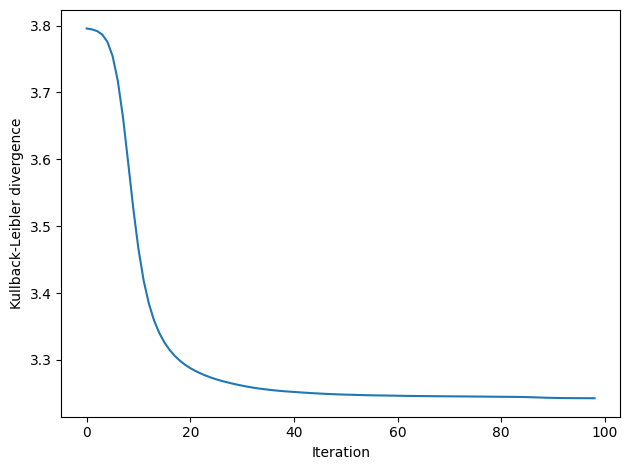

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
_ = visualize.convergence(ax)
fig.tight_layout()

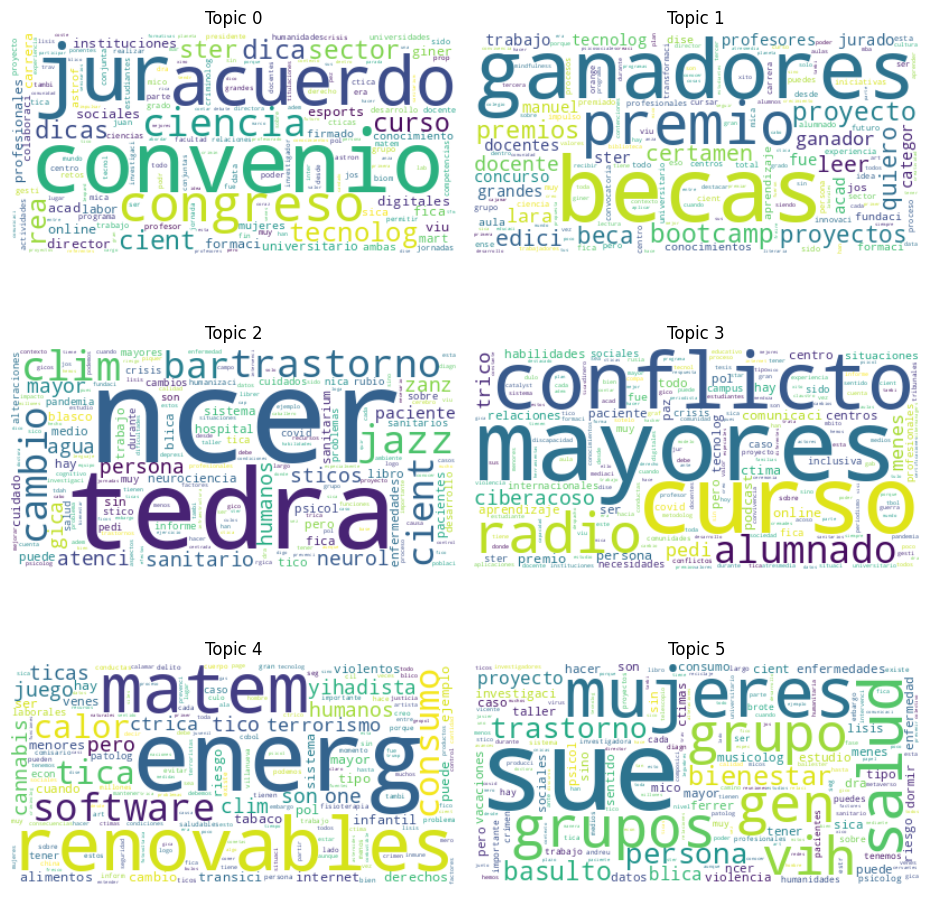

In [ ]:
fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)

# MODELO LDA

In [ ]:
from gensim.models import LdaModel

In [ ]:
lda = LdaModel(corpus=corpus, id2word=diccionario,
               num_topics=10, random_state=1,
               chunksize=500, passes=10, alpha='auto')

Veamos los tópicos obtenidos y las 8 palabras que más describen cada tópico, así como su peso

In [ ]:
topicos = lda.print_topics(num_words=8, num_topics=10)
for topico in topicos:
    print(topico)

(0, '0.020*"person" + 0.013*"mayor" + 0.009*"salud" + 0.007*"trastorn" + 0.006*"deb" + 0.006*"tratamient" + 0.006*"cas" + 0.006*"psicolog"')
(1, '0.030*"investig" + 0.014*"sanitari" + 0.011*"salud" + 0.011*"profesional" + 0.010*"proyect" + 0.009*"grup" + 0.009*"trabaj" + 0.009*"dr"')
(2, '0.015*"premi" + 0.015*"proyect" + 0.014*"astronom" + 0.014*"docent" + 0.014*"lectur" + 0.011*"educ" + 0.011*"mast" + 0.009*"enseñ"')
(3, '0.017*"derech" + 0.013*"social" + 0.012*"polit" + 0.009*"justici" + 0.008*"conflict" + 0.007*"europe" + 0.007*"deb" + 0.007*"human"')
(4, '0.032*"trabaj" + 0.022*"riesg" + 0.020*"laboral" + 0.015*"canc" + 0.013*"prevencion" + 0.011*"segur" + 0.009*"salud" + 0.008*"psicolog"')
(5, '0.009*"hac" + 0.006*"cambi" + 0.006*"deb" + 0.006*"pod" + 0.006*"ser" + 0.005*"si" + 0.005*"tecnolog" + 0.005*"econom"')
(6, '0.016*"music" + 0.016*"premi" + 0.012*"musical" + 0.009*"investig" + 0.008*"reconoc" + 0.008*"escritor" + 0.007*"celebr" + 0.007*"histori"')
(7, '0.018*"educ" + 0.0

Veamos como clasificaría a la noticia que hemos ido observando a lo largo del cuaderno (contenidos[701][0])

In [ ]:
topic_modelling = lda[corpus[701]]
topic_modelling

[(2, 0.79416823), (7, 0.20239522)]

Observamos que asigna a este documento el tópico 2 con una contribución del 79% y el 7 con una contribución del 21%. Según hemos obtenido, el tópico 2 está relacionado con los premios, proyectos, lectura... y el 7 con la educación, luego la clasificación ha sido bastante buena, teniendo en cuenta el contenido de la noticia.

Veamos cual era el contenido de la noticia

In [ ]:
cuerpo_noticia=[]
page = requests.get(enlaces_noticias[702])
soup = BeautifulSoup(page.content, "html.parser")
cuerpo_noticia.append([json.loads(soup.find("script", type="application/ld+json").text)["@graph"][0]["articleBody"]])
print(cuerpo_noticia)

[["\r\n\r\nOrganizado y convocado por la&nbsp;Universidad Internacional de Valencia&nbsp;(VIU) y la&nbsp;Fundación José Manuel Lara&nbsp;(FJML), este certamen tiene como objetivo&nbsp;“contribuir a la divulgación, fomento, desarrollo, investigación y protección del hábito de la lectura”, tal y como se especifica en el&nbsp;Plan Nacional de Fomento de la Lectura&nbsp;puesto en marcha por el Ministerio de Cultura y Deportes/Ministerio de Educación y Formación Profesional. Este concurso está dirigido al&nbsp;personal docente de los Centros de Enseñanza de Secundaria&nbsp;en Andalucía, con independencia de la materia que imparta dentro del aula.\r\n\r\n&nbsp;\r\n\r\nCada docente participante seleccionará la mejor idea innovadora que haya diseñado en el ámbito del fomento de la lectura en un centro docente y la plasmará en un documento que podrá descargarse a través de la web de la Fundación José Manuel Lara. Pueden consultarse todos los requisitos de participación y las bases en la siguien

In [ ]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
def valores_coherencia(diccionario, corpus, noticias, limit, start=2, step=2):
  valores_coherencia = []
  lista_modelos = []
  for numero_topicos in range(start, limit, step):
    model=LdaModel(corpus=corpus, id2word=diccionario, num_topics=numero_topicos, random_state=1, chunksize=800, passes=10, alpha='auto')
    lista_modelos.append(model)
    coherencemodel = CoherenceModel(model=model, texts=noticias, dictionary=diccionario,
    coherence='c_v')
    valores_coherencia.append(coherencemodel.get_coherence())
  return lista_modelos, valores_coherencia


In [ ]:
lista_modelos, valores_coherencia = valores_coherencia(diccionario,corpus,[contenidos[i][0] for i in range(len(contenidos))],16,4,1)

In [ ]:
for i in range(len(lista_modelos)):
  print("El modelo",lista_modelos[i],"tiene un valor de coherencia de",valores_coherencia[i])

El modelo LdaModel<num_terms=8300, num_topics=4, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.34787802579682636
El modelo LdaModel<num_terms=8300, num_topics=5, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.3832759563645271
El modelo LdaModel<num_terms=8300, num_topics=6, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.3974587918491889
El modelo LdaModel<num_terms=8300, num_topics=7, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.37579143958679395
El modelo LdaModel<num_terms=8300, num_topics=8, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.3611600292035645
El modelo LdaModel<num_terms=8300, num_topics=9, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.4007842966238376
El modelo LdaModel<num_terms=8300, num_topics=10, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.3754925560179516
El modelo LdaModel<num_terms=8300, num_topics=11, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.36140

Similitud entre textos (usando la distancia de Jensen-Shannon)

In [ ]:
from gensim.matutils import jensen_shannon

Usaremos la función que tiene gensim implementada

In [ ]:
def calcular_distanciajensen_shannon(doc_1, doc_2):

    return jensen_shannon(doc_1, doc_2)

Por otro lado, se puede utilizar la siguiente función para sugerir noticias similares a un usuario que esté buscando una noticia en concreto

In [ ]:
def similares(noticia, n_similares):
  distancias = [calcular_distanciajensen_shannon(lda.get_document_topics(corpus[noticia],
                                               minimum_probability=0), lda.get_document_topics(corpus[i],
                                               minimum_probability=0)) for i in range(len(corpus))]
  mas_similares = np.argsort(distancias)[0:n_similares] #usamos argsort porque queremos encontrar aquellas noticias con las distancias más bajas
  return mas_similares

Busquemos las 10 noticias más relacionadas con la informada, ponemos 11 ya que en principio la propia noticia tendrá la menor distancia con ella misma. Lo dejamos y no lo sacamos del bucle porque está bien para comprobar el resultado de la distancia.

In [ ]:
noticias_mas_similares=similares(701,11)

In [ ]:
noticias_mas_similares

array([701, 554, 495, 263, 159, 562, 629, 314, 516, 619, 387])

In [ ]:
for i in noticias_mas_similares:
  print(enlaces_noticias[i])

https://www.universidadviu.com/es/actualidad/noticias/santiago-posteguillo-premio-planeta-2018-impartira-una-masterclass-sobre-su
https://www.universidadviu.com/es/actualidad/noticias/la-universidad-internacional-de-valencia-y-aulaplaneta-lanzan-la-cuarta-edicion
https://www.universidadviu.com/es/actualidad/noticias/la-universidad-internacional-de-valencia-presenta-su-nueva-campana-invitando
https://www.universidadviu.com/es/actualidad/noticias/el-dr-cristobal-torres-fernandez-investigador-y-docente-de-viu-encabeza-la-fundacion-de-una-red-iberoamericana-de-investigacion-educativa
https://www.universidadviu.com/es/actualidad/noticias/las-i-jornadas-de-la-catedra-en-neurociencia-global-y-cambio-social-se-celebran-con-exito-de-participacion
https://www.universidadviu.com/es/actualidad/noticias/el-periodista-presentador-y-docente-de-viu-vicente-valles-recibe-el-premio-de
https://www.universidadviu.com/es/actualidad/noticias/la-universidad-internacional-de-valencia-se-adapta-las-nuevas-tend

# MODELO NNMF

In [70]:
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

In [69]:
def valores_coherencia(diccionario, corpus, noticias, limit, start=2, step=2):
  valores_coherencia = []
  lista_modelos = []
  for numero_topicos in range(start, limit, step):
    model=Nmf(corpus=corpus, id2word=diccionario, num_topics=numero_topicos,chunksize=800, random_state=2, passes=10,normalize=True)
    lista_modelos.append(model)
    coherencemodel = CoherenceModel(model=model, texts=noticias, dictionary=diccionario,coherence='c_v')
    valores_coherencia.append(coherencemodel.get_coherence())
  return lista_modelos, valores_coherencia

In [ ]:
lista_modelos, valores_coherencia = valores_coherencia(diccionario,corpus,[contenidos[i][0] for i in range(len(contenidos))],15,3,1)

In [ ]:
for i in range(len(lista_modelos)):
  print("El modelo",lista_modelos[i],"tiene un valor de coherencia de",valores_coherencia[i])

El modelo <gensim.models.nmf.Nmf object at 0x7810d7702c80> tiene un valor de coherencia de 0.40159667092053153
El modelo <gensim.models.nmf.Nmf object at 0x7811009afdc0> tiene un valor de coherencia de 0.36628213323698117
El modelo <gensim.models.nmf.Nmf object at 0x781154a6f7f0> tiene un valor de coherencia de 0.38445429209867843
El modelo <gensim.models.nmf.Nmf object at 0x7810d75eabc0> tiene un valor de coherencia de 0.420918114985898
El modelo <gensim.models.nmf.Nmf object at 0x7810d75eb280> tiene un valor de coherencia de 0.39658875935654925
El modelo <gensim.models.nmf.Nmf object at 0x781145205d50> tiene un valor de coherencia de 0.41199216750219636
El modelo <gensim.models.nmf.Nmf object at 0x7811452059c0> tiene un valor de coherencia de 0.41252911950679516
El modelo <gensim.models.nmf.Nmf object at 0x78118d3af550> tiene un valor de coherencia de 0.3688455234760571
El modelo <gensim.models.nmf.Nmf object at 0x781145054be0> tiene un valor de coherencia de 0.3886894095795123
El mo

In [ ]:
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
valores_coherencia

[0.40159667092053153,
 0.36628213323698117,
 0.38445429209867843,
 0.420918114985898,
 0.39658875935654925,
 0.41199216750219636,
 0.41252911950679516,
 0.3688455234760571,
 0.3886894095795123,
 0.4086000802822061,
 0.3818048767266333,
 0.37266675400111055]

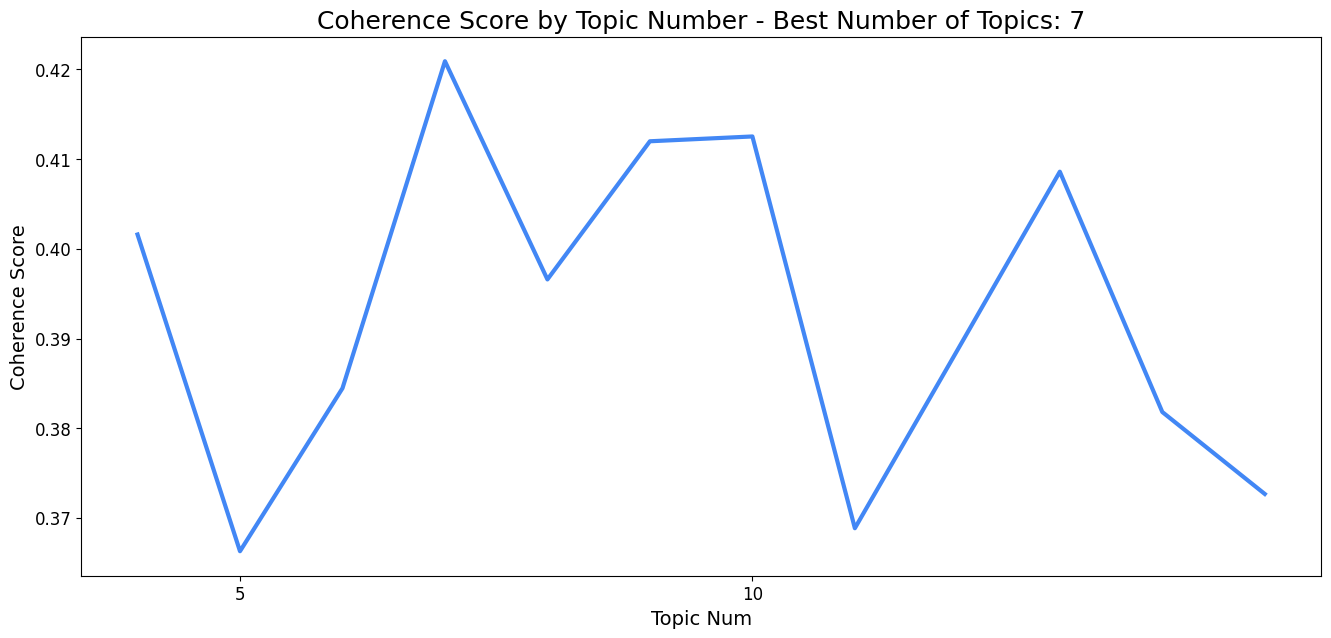

In [ ]:
num_topicos=topic_nums = list(np.arange(4, 16, 1))
scores = list(zip(num_topicos, valores_coherencia))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(16, 7))

plt.plot(
    num_topicos,
    valores_coherencia,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5,max(num_topicos), 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

# Redes neuronales recurrentes (LSTM bidireccional)

Lo emplearemos para el diario La Razón, para ello extraeremos 280 noticias de cada una de las 9 secciones principales de su web.Para ello extraeremos noticias de las 20 primeras páginas de cada sección, pues hay 14 noticias en cada página. En total extaeremos 2520 noticias.

In [ ]:
temas=["espana","internacional","economia","sociedad","opinion","deportes","cultura","salud","gente"]
enlace_noticias=[]
for t in temas:
  URL = "https://www.larazon.es/"+t+"/"
  page = requests.get(URL)
  soup = BeautifulSoup(page.content, "html.parser")
  extracción1=soup.find_all("section", class_="row distributiva")
  for i in range(len(extracción1)):
    extracción2=extracción1[i].find_all("a", class_="article__media video")
    for j in range(len(extracción2)):
      enlace_noticias.append((extracción2[j].attrs["href"],t))
  print(len(enlace_noticias))
  for p in range(2,21):
    URL = "https://www.larazon.es/"+t+"/"+str(p)+"/"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    extracción1=soup.find_all("section", class_="row distributiva")
    for i in range(len(extracción1)):
      extracción2=extracción1[i].find_all("a", class_="article__media video")
      for j in range(len(extracción2)):
        enlace_noticias.append((extracción2[j].attrs["href"],t))
    print(len(enlace_noticias))



14
28
42
56
70
84
98
112
126
140
154
168
182
196
210
224
238
252
266
280
294
308
322
336
350
364
378
392
406
420
434
448
462
476
490
504
518
532
546
560
574
588
602
616
630
644
658
672
686
700
714
728
742
756
770
784
798
812
826
840
854
868
882
896
910
924
938
952
966
980
994
1008
1022
1036
1050
1064
1078
1092
1106
1120
1134
1148
1162
1176
1190
1204
1218
1232
1246
1260
1274
1288
1302
1316
1330
1344
1358
1372
1386
1400
1414
1428
1442
1456
1470
1484
1498
1512
1526
1540
1554
1568
1582
1596
1610
1624
1638
1652
1666
1680
1694
1708
1722
1736
1750
1764
1778
1792
1806
1820
1834
1848
1862
1876
1890
1904
1918
1932
1946
1960
1974
1988
2002
2016
2030
2044
2058
2072
2086
2100
2114
2128
2142
2156
2170
2184
2198
2212
2226
2240
2254
2268
2282
2296
2310
2324
2338
2352
2366
2380
2394
2408
2422
2436
2450
2464
2478
2492
2506
2520


In [ ]:
enlace_noticias

[('https://www.larazon.es/espana/insta-sanchez-dejar-tomar-sol-conocer-realidad-migratoria-canarias_2023081464da452c9598e30001bdc7f5.html',
  'espana'),
 ('https://www.larazon.es/espana/armada-despliega-buque-otan-mediterraneo-vigilar-buques-rusos_2023081464da31739598e30001bd99d6.html',
  'espana'),
 ('https://www.larazon.es/espana/aboga-investidura-rapida-gobierno-solitario-feijoo_2023081464da2807714dff000107da00.html',
  'espana'),
 ('https://www.larazon.es/espana/ayuso-critica-condecoracion-gamez-cese-cobos-siguiente-otorgar-gran-cruz-orden-isabel-catolica-puigdemont_2023081464da20655df8e30001cb61a7.html',
  'espana'),
 ('https://www.larazon.es/espana/junts-apura-final-decidira-mismo-jueves-entrega-presidencia-congreso-psoe_2023081464da19d79598e30001bd6133.html',
  'espana'),
 ('https://www.larazon.es/espana/familiares-presos-manifestaran-bilbao-que-etarras-vuelvan-casa_2023081464da0b2d714dff0001078d74.html',
  'espana'),
 ('https://www.larazon.es/espana/sumar-pide-papel-importante-

In [ ]:
lista = enlace_noticias
mi_path = "/content/enlaces.txt"

with open(mi_path, 'a+') as f:
    for i in lista:
        f.write(str(i))

In [ ]:
len(enlace_noticias)

2520

In [ ]:
contenidos=[]
contador=0


for i in enlace_noticias:
  if len(i[0])>2 and "directo" not in str(i[0]):
    print(i[0])
    page = requests.get(i[0])
    soup = BeautifulSoup(page.content, "html.parser")
    if soup.find("script", type="application/ld+json")!=None:
      if "articleBody" in json.loads(soup.find("script", type="application/ld+json").text):
        contenidos.append([json.loads(soup.find("script", type="application/ld+json").text)["articleBody"],i[1]])
        contador+=1
        print(contador)

https://www.larazon.es/espana/insta-sanchez-dejar-tomar-sol-conocer-realidad-migratoria-canarias_2023081464da452c9598e30001bdc7f5.html
1
https://www.larazon.es/espana/armada-despliega-buque-otan-mediterraneo-vigilar-buques-rusos_2023081464da31739598e30001bd99d6.html
2
https://www.larazon.es/espana/aboga-investidura-rapida-gobierno-solitario-feijoo_2023081464da2807714dff000107da00.html
3
https://www.larazon.es/espana/ayuso-critica-condecoracion-gamez-cese-cobos-siguiente-otorgar-gran-cruz-orden-isabel-catolica-puigdemont_2023081464da20655df8e30001cb61a7.html
4
https://www.larazon.es/espana/junts-apura-final-decidira-mismo-jueves-entrega-presidencia-congreso-psoe_2023081464da19d79598e30001bd6133.html
5
https://www.larazon.es/espana/familiares-presos-manifestaran-bilbao-que-etarras-vuelvan-casa_2023081464da0b2d714dff0001078d74.html
6
https://www.larazon.es/espana/sumar-pide-papel-importante-mesa-congreso-reconoce-contactos-junts_2023081464da0376714dff0001077a7b.html
7
https://www.larazon.

Solo quitaremos los caracteres especiales y elementos forzados de HTML, es decir realizaremos la acción de nuestra función "preprocesamiento". Sin embargo, no eliminaremos stopwords ni realizaremos "stemming" porque en LSTM interesa mantener la coherencia y trazabilidad de la oración al completo.

In [ ]:
for i in range(len(contenidos)):
  contenidos[i][0]=preprocesamiento(contenidos[i][0])


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional,BatchNormalization,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam

df = pd.DataFrame(contenidos)

print(df)

                                                      0       1
0     el verano ha disparado la llegada de migrantes...  espana
1     las fuerzas armadas españolas comienzan el vie...  espana
2     el coordinador general del pp diputado naciona...  espana
3     en sus redes sociales ayuso ha hecho un parale...  espana
4     hasta el final con la incógnita la constitució...  espana
...                                                 ...     ...
2488  ya avisó él que esto va para largo así que nad...   gente
2489  durante veinticinco años patricia cerezo fue l...   gente
2490  a pesar de sus firmes intenciones de permanece...   gente
2491  tamara falcó no está tan lejos como para olvid...   gente
2492  albert rivera se encuentra viviendo su primer ...   gente

[2493 rows x 2 columns]


In [ ]:
df.columns = ['contenido', 'etiqueta']
df

,contenido,etiqueta
0,el verano ha disparado la llegada de migrantes...,espana
1,las fuerzas armadas españolas comienzan el vie...,espana
2,el coordinador general del pp diputado naciona...,espana
3,en sus redes sociales ayuso ha hecho un parale...,espana
4,hasta el final con la incógnita la constitució...,espana
...,...,...
2488,ya avisó él que esto va para largo así que nad...,gente
2489,durante veinticinco años patricia cerezo fue l...,gente
2490,a pesar de sus firmes intenciones de permanece...,gente
2491,tamara falcó no está tan lejos como para olvid...,gente


In [ ]:
mapeos = {
  0: "espana",
  1: "internacional",
  2: "economia",
  3: "sociedad",
  4: "opinion",
  5: "deportes",
  6: "cultura",
  7: "salud",
  8: "gente"
}

In [ ]:
df.drop(df[(df["contenido"].str.len()<200)].index,inplace=True)

In [ ]:
df['etiqueta'] = df['etiqueta'].replace(
  # Reemplaza cada valor por el valor en la segunda lista en el mismo índice del match.
  mapeos.values(), # Lista de Strings
  mapeos.keys() # Lista de Números
)
df

,contenido,etiqueta
0,el verano ha disparado la llegada de migrantes...,0
1,las fuerzas armadas españolas comienzan el vie...,0
2,el coordinador general del pp diputado naciona...,0
3,en sus redes sociales ayuso ha hecho un parale...,0
4,hasta el final con la incógnita la constitució...,0
...,...,...
2488,ya avisó él que esto va para largo así que nad...,8
2489,durante veinticinco años patricia cerezo fue l...,8
2490,a pesar de sus firmes intenciones de permanece...,8
2491,tamara falcó no está tan lejos como para olvid...,8


In [ ]:
train_data, test_data = train_test_split(df[['contenido', 'etiqueta']], test_size=0.1)

training_sentences = list(train_data['contenido'])
training_labels = list(train_data['etiqueta'])

testing_sentences = list(test_data['contenido'])
testing_labels = list(test_data['etiqueta'])
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
from keras.utils import to_categorical
training_labels_final=to_categorical(training_labels)
testing_labels_final=to_categorical(testing_labels)

In [ ]:
testing_labels_final[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
vocabulario= 20000   # limit vector of words to the top 20,000 words
embedding_dim = 64
max_length = 200
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocabulario, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [ ]:
testing_padded[0]

array([   14,   924,   416,     6,   541,     3,  1257,    93,     9,
        4303,  1278,    63,    19,  5280,  2384,     4,  1960,    10,
         394, 12306,    16,    42,  2311,    13,     7,   645,    23,
          14, 14739,    11,     4,   272,    14,   214,   924,     3,
         908,    35,    14,     1,     9,   103,    17,   235,     1,
        1990,    13,    12,   815,     2,     9,  4303,  1278,     5,
           1,    63, 10793,  7304,    17,   874,     2,    42,    14,
         113,     2,  7497,     4,     1,     5,  7101, 13280,     3,
        1219,   398,    20,  9005,   398,    14,   924,   416,     6,
         541,    21,    83,    13,     5,   114,     3,  1727,     2,
        3860,     2,    98,     8,   188,     2,   166,  5712,     3,
        7026,     2,    14,   363,     2,   407,    18,  3000,    16,
       16836,     5,   671,   927,     6,   541,     6,   449,   256,
         214,   129,    17,  1285,     4,     3,   924,   152,  4740,
         333,     4,

In [ ]:
!pip freeze
!pip install -q -U keras-tuner
import kerastuner as kt

absl-py==1.4.0
aiohttp==3.8.5
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.3.1
altair==4.2.2
annotated-types==0.5.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.4.1
arviz==0.15.1
astropy==5.3.1
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
audioread==3.0.0
autograd==1.6.2
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.4
blis==0.7.10
blosc2==2.0.0
bokeh==3.2.1
branca==0.6.0
build==0.10.0
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.9
certifi==2023.7.22
cffi==1.15.1
chardet==4.0.0
charset-normalizer==3.2.0
chex==0.1.7
click==8.1.6
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.1
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.1.1
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.0
convertdate==2.4.0
cryptography==41.0.3
cufflinks==0.17.3
cvxopt==1.3.2
cvxpy==1.3.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.36
dask==2023.8.0
datascience==0

<ipython-input-20-6143d6335671>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
def model_builder(hp):

  hp_units = hp.Int('units', min_value = 32, max_value = 128, step = 32)
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
  hp_rate = hp.Float('rate', min_value = 0.2, max_value = 0.5, step = 0.1)
  hp_l2=hp.Choice('l2', values = [1e-2,2e-2, 1e-3,2e-3, 1e-4,2e-4])

  # Creamos la arquitectura LSTM
  embedding_vector_length = 64
  model = Sequential()
  model.add(Embedding(vocabulario, embedding_vector_length, input_length=max_length))
  model.add(Bidirectional(LSTM(90,recurrent_dropout=0.25,dropout=0.1)))
  model.add(Dense(units = hp_units, kernel_regularizer=tf.keras.regularizers.l2(hp_l2), activation='relu')),
  model.add(BatchNormalization()),
  model.add(Dropout(rate=hp_rate)),
  model.add(Dense(units = hp_units, kernel_regularizer=tf.keras.regularizers.l2(hp_l2), activation='relu')),
  model.add(BatchNormalization()),
  model.add(Dropout(rate=hp_rate)),
  model.add(Dense(9, activation='softmax'))
  # Compilamos el modelo
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = hp_learning_rate), metrics=['accuracy'])
  return model



In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

import tensorflow as tf
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)


from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,Callback
parada_temprana = EarlyStopping(monitor='val_loss',patience=2, verbose=1,min_delta=1e-4)
reducir_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=1,verbose=1)
checkpoint = ModelCheckpoint(filepath='mejormodelo.h5',monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
callbacks_list = [parada_temprana, reducir_lr,ClearTrainingOutput(),checkpoint]

In [ ]:
tuner.search(padded, training_labels_final, epochs=10, validation_split=0.10, batch_size=32, callbacks = [callbacks_list])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
La optimización ha terminado. El número óptimo de neuronas en las capas densas es de {best_hps.get('units')} y , el porcentaje óptimo de dropout es {best_hps.get('rate')*100} y la tasa
optima de aprendizaje es de {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 10m 30s]
val_accuracy: 0.15837104618549347

Best val_accuracy So Far: 0.5475113391876221
Total elapsed time: 02h 03m 02s

La optimización ha terminado. El número óptimo de neuronas en las capas densas es de 32 y , el porcentaje óptimo de dropout es 20.0 y la tasa 
optima de aprendizaje es de 0.001.



Entrenamos el modelo que mejor precisión obtuvo

In [ ]:
# Creamos la arquitectura LSTM
embedding_vector_length = 64
model = Sequential()
model.add(Embedding(vocabulario, embedding_vector_length, input_length=max_length))
model.add(Bidirectional(LSTM(90,recurrent_dropout=0.25,dropout=0.1)))
model.add(Dense(units = 32, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu')),
model.add(BatchNormalization()),
model.add(Dropout(rate=0.2)),
model.add(Dense(units = 32, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='relu')),
model.add(BatchNormalization()),
model.add(Dropout(rate=0.2)),
model.add(Dense(9, activation='softmax'))
print(model.summary())

precisiones=[]
contador=0
# Entrenamos el modelo
for i in [8,10,12,14,16] :
  for j in [32,64,128,256]:
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])
    model.fit(padded, training_labels_final, epochs=i, validation_split=0.1, batch_size=j,callbacks = [callbacks_list])
    # Evaluamos el modelo
    scores = model.evaluate(testing_padded, testing_labels_final, verbose=0)
    precisiones.append(scores[1]*100)
    print("Accuracy: %.2f%% para %a épocas y tamaño de lote %a" % (precisiones[contador]*100,i,j))
    contador+=1

Accuracy: 5306.12% para 10 épocas y tamaño de lote 32
Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9753
Epoch 1: val_accuracy did not improve from 0.57919
31/31 [==============================] - 45s 1s/step - loss: 0.1354 - accuracy: 0.9753 - val_loss: 2.1306 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9773
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_accuracy did not improve from 0.57919
31/31 [==============================] - 35s 1s/step - loss: 0.1170 - accuracy: 0.9773 - val_loss: 2.2496 - val_accuracy: 0.4661 - lr: 0.0010
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9803
Epoch 3: val_accuracy did not improve from 0.57919
31/31 [==============================] - 37s 1s/step - loss: 0.1088 - accuracy: 0.9803 - val_loss: 1.9623 - val_accuracy: 0.5204 - lr: 1.0000e-04
Epo

KeyboardInterrupt: ignored

# LDA con La Razón

In [ ]:
temas=["espana","internacional","economia","sociedad","opinion","deportes","cultura","salud","gente"]
enlace_noticias=[]
for t in temas:
  URL = "https://www.larazon.es/"+t+"/"
  page = requests.get(URL)
  soup = BeautifulSoup(page.content, "html.parser")
  extracción1=soup.find_all("section", class_="row distributiva")
  for i in range(len(extracción1)):
    extracción2=extracción1[i].find_all("a", class_="article__media video")
    for j in range(len(extracción2)):
      enlace_noticias.append((extracción2[j].attrs["href"],t))
  print(len(enlace_noticias))
  for p in range(2,21):
    URL = "https://www.larazon.es/"+t+"/"+str(p)+"/"
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")
    extracción1=soup.find_all("section", class_="row distributiva")
    for i in range(len(extracción1)):
      extracción2=extracción1[i].find_all("a", class_="article__media video")
      for j in range(len(extracción2)):
        enlace_noticias.append((extracción2[j].attrs["href"],t))
    print(len(enlace_noticias))



14
28
42
56
70
84
98
112
126
140
154
168
182
196
210
224
238
252
266
280
294
308
322
336
350
364
378
392
406
420
434
448
462
476
490
504
518
532
546
560
574
588
602
616
630
644
658
672
686
700
714
728
742
756
770
784
798
812
826
840
854
868
882
896
910
924
938
952
966
980
994
1008
1022
1036
1050
1064
1078
1092
1106
1120
1134
1148
1162
1176
1190
1204
1218
1232
1246
1260
1274
1288
1302
1316
1330
1344
1358
1372
1386
1400
1414
1428
1442
1456
1470
1484
1498
1512
1526
1540
1554
1568
1582
1596
1610
1624
1638
1652
1666
1680
1694
1708
1722
1736
1750
1764
1778
1792
1806
1820
1834
1848
1862
1876
1890
1904
1918
1932
1946
1960
1974
1988
2002
2016
2030
2044
2058
2072
2086
2100
2114
2128
2142
2156
2170
2184
2198
2212
2226
2240
2254
2268
2282
2296
2310
2324
2338
2352
2366
2380
2394
2408
2422
2436
2450
2464
2478
2492
2506
2520


In [ ]:
enlace_noticias

[('https://www.larazon.es/espana/esquerra-echa-freno-ahora-deja-aire-apoyo-psoe-presidir-congreso_2023081364d8be1e714dff0001056159.html',
  'espana'),
 ('https://www.larazon.es/espana/nueva-meta-volante-carrera_2023081364d89c7d9598e30001bad6de.html',
  'espana'),
 ('https://www.larazon.es/espana/inconfesable_2023081364d82bfa714dff00010492f0.html',
  'espana'),
 ('https://www.larazon.es/espana/exito-puigdemont_2023081364d82a565df8e30001c8266c.html',
  'espana'),
 ('https://www.larazon.es/espana/ivan-espinosa-monteros-purgas-deserciones_2023081364d7c724714dff000103ee58.html',
  'espana'),
 ('https://www.larazon.es/espana/asi-sera-nuevo-congreso-diputados-menos-gallinero-mas-tecnicos_2023081364d81b4b9598e30001ba28c8.html',
  'espana'),
 ('https://www.larazon.es/espana/junts-agita-semana-clave-exige-brexit-catalan_2023081364d819e95df8e30001c80f24.html',
  'espana'),
 ('https://www.larazon.es/espana/israel-recibe-primeras-entregas-misil-israeli-barak_2023081264d7b8635df8e30001c76d1f.html',


In [ ]:
lista = enlace_noticias
mi_path = "/content/enlaces.txt"

with open(mi_path, 'a+') as f:
    for i in lista:
        f.write(str(i))

In [ ]:
len(enlace_noticias)

2520

In [ ]:
contenidos=[]
contador=0


for i in enlace_noticias:
  if len(i[0])>2 and "directo" not in str(i[0]):
    print(i[0])
    page = requests.get(i[0])
    soup = BeautifulSoup(page.content, "html.parser")
    if soup.find("script", type="application/ld+json")!=None:
      if "articleBody" in json.loads(soup.find("script", type="application/ld+json").text):
        contenidos.append([json.loads(soup.find("script", type="application/ld+json").text)["articleBody"],i[1]])
        contador+=1
        print(contador)

https://www.larazon.es/espana/esquerra-echa-freno-ahora-deja-aire-apoyo-psoe-presidir-congreso_2023081364d8be1e714dff0001056159.html
1
https://www.larazon.es/espana/nueva-meta-volante-carrera_2023081364d89c7d9598e30001bad6de.html
2
https://www.larazon.es/espana/inconfesable_2023081364d82bfa714dff00010492f0.html
3
https://www.larazon.es/espana/exito-puigdemont_2023081364d82a565df8e30001c8266c.html
4
https://www.larazon.es/espana/ivan-espinosa-monteros-purgas-deserciones_2023081364d7c724714dff000103ee58.html
5
https://www.larazon.es/espana/asi-sera-nuevo-congreso-diputados-menos-gallinero-mas-tecnicos_2023081364d81b4b9598e30001ba28c8.html
6
https://www.larazon.es/espana/junts-agita-semana-clave-exige-brexit-catalan_2023081364d819e95df8e30001c80f24.html
7
https://www.larazon.es/espana/israel-recibe-primeras-entregas-misil-israeli-barak_2023081264d7b8635df8e30001c76d1f.html
8
https://www.larazon.es/espana/sospecha-que-calvino-marcha-europa-porque-sanchez-tener-votos-investidura_2023081264d

In [ ]:
from gensim.models import LdaModel

In [ ]:
lda = LdaModel(corpus=corpus, id2word=diccionario,
               num_topics=9, random_state=1,
               chunksize=500, passes=10, alpha='auto')

In [ ]:
topicos = lda.print_topics(num_words=8, num_topics=9)
for topico in topicos:
    print(topico)

(0, '0.015*"quot" + 0.009*"sanch" + 0.008*"cas" + 0.007*"años" + 0.006*"daniel" + 0.006*"investig" + 0.005*"hij" + 0.005*"polic"')
(1, '0.016*"pais" + 0.010*"rus" + 0.010*"guerr" + 0.009*"rusi" + 0.008*"ucrani" + 0.007*"president" + 0.006*"unid" + 0.006*"fuerz"')
(2, '0.257*"quot" + 0.005*"asegur" + 0.004*"segun" + 0.004*"explic" + 0.003*"inform" + 0.003*"embarc" + 0.003*"tras" + 0.003*"lleg"')
(3, '0.014*"part" + 0.013*"polit" + 0.012*"gobiern" + 0.011*"sanchez" + 0.010*"vot" + 0.008*"pp" + 0.008*"eleccion" + 0.008*"president"')
(4, '0.014*"equip" + 0.012*"part" + 0.009*"jugador" + 0.008*"club" + 0.008*"pas" + 0.008*"futbol" + 0.007*"deport" + 0.007*"tempor"')
(5, '0.009*"hac" + 0.006*"vid" + 0.006*"si" + 0.006*"pas" + 0.005*"sol" + 0.005*"ser" + 0.005*"dej" + 0.004*"pued"')
(6, '0.017*"millon" + 0.015*"eur" + 0.012*"año" + 0.008*"mes" + 0.006*"españ" + 0.005*"medi" + 0.005*"preci" + 0.005*"empres"')
(7, '0.012*"pued" + 0.008*"salud" + 0.008*"estudi" + 0.007*"quot" + 0.007*"investig" 

In [ ]:
# Plotting tools
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

def format_topics_sentences(ldamodel=lda, corpus=corpus, texts=[contenidos[i][0] for i in range(len(contenidos))]):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=[contenidos[i][0] for i in range(len(contenidos))])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.7242,"part, polit, gobiern, sanchez, vot, pp, elecci...","[antoni, castellà, portavoz, polit, demòcrat, ..."
1,1,3,0.9606,"part, polit, gobiern, sanchez, vot, pp, elecci...","[lid, pp, albert, nuñez, feijo, sig, busc, for..."
2,2,3,0.8724,"part, polit, gobiern, sanchez, vot, pp, elecci...","[españ, vuelt, entrar, funcion, lej, result, u..."
3,3,3,0.3893,"part, polit, gobiern, sanchez, vot, pp, elecci...","[transferent, competent, autonom, escas, prese..."
4,4,3,0.5261,"part, polit, gobiern, sanchez, vot, pp, elecci...","[xunt, pol, irix, pso, formaliz, viern, presen..."
...,...,...,...,...,...
2489,2489,5,0.6973,"hac, vid, si, pas, sol, ser, dej, pued, ahor, ...","[chabeli, navarr, regres, program, emma, garc,..."
2490,2490,5,0.9540,"hac, vid, si, pas, sol, ser, dej, pued, ahor, ...","[dobl, notici, lleg, titular, corazon, ultim, ..."
2491,2491,5,0.7361,"hac, vid, si, pas, sol, ser, dej, pued, ahor, ...","[ide, descabell, sin, probabil, real, mar, pat..."
2492,2492,5,0.6833,"hac, vid, si, pas, sol, ser, dej, pued, ahor, ...","[lleg, veran, sab, quien, saldr, victori, cuer..."


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9700,"quot, sanch, cas, años, daniel, investig, hij,...","[investig, asesinat, cirujan, plastic, colombi..."
1,1,0.9896,"pais, rus, guerr, rusi, ucrani, president, uni...","[ministeri, exterior, franci, comenz, ayer, op..."
2,2,0.8480,"quot, asegur, segun, explic, inform, embarc, t...","[men, person, muert, tres, result, her, tras, ..."
3,3,0.9971,"part, polit, gobiern, sanchez, vot, pp, elecci...","[ciudadan, habl, ahor, toc, sac, calcul, cit, ..."
4,4,0.9170,"equip, part, jugador, club, pas, futbol, depor...","[jill, roord, mediocentr, neerlandes, abri, ma..."
5,5,0.9950,"hac, vid, si, pas, sol, ser, dej, pued, ahor, ...","[jesulin, ubriqu, nunc, sid, hombr, demasi, al..."
6,6,0.9957,"millon, eur, año, mes, españ, medi, preci, emp...","[españ, registr, ener, juli, proced, concursal..."
7,7,0.9971,"pued, salud, estudi, quot, investig, person, p...","[estim, españ, exist, medi, millon, cas, demen..."
8,8,0.9199,"español, agost, tor, dos, juli, españ, mar, re...","[empres, plaza1, llev, destin, paz, tor, vent,..."


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num','Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"quot, sanch, cas, años, daniel, investig, hij,...",263,0.1055
1,1,"pais, rus, guerr, rusi, ucrani, president, uni...",141,0.0565
2,2,"quot, asegur, segun, explic, inform, embarc, t...",54,0.0217
3,3,"part, polit, gobiern, sanchez, vot, pp, elecci...",354,0.1419
4,4,"equip, part, jugador, club, pas, futbol, depor...",191,0.0766
5,5,"hac, vid, si, pas, sol, ser, dej, pued, ahor, ...",685,0.2747
6,6,"millon, eur, año, mes, españ, medi, preci, emp...",294,0.1179
7,7,"pued, salud, estudi, quot, investig, person, p...",352,0.1411
8,8,"español, agost, tor, dos, juli, españ, mar, re...",160,0.0642


In [ ]:
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
def valores_coherencia(diccionario, corpus, noticias, limit, start=2, step=2):
  valores_coherencia = []
  lista_modelos = []
  for numero_topicos in range(start, limit, step):
    model=LdaModel(corpus=corpus, id2word=diccionario, num_topics=numero_topicos, random_state=1, chunksize=800, passes=10, alpha='auto')
    lista_modelos.append(model)
    coherencemodel = CoherenceModel(model=model, texts=noticias, dictionary=diccionario,
    coherence='c_v')
    valores_coherencia.append(coherencemodel.get_coherence())
  return lista_modelos, valores_coherencia


In [ ]:
lista_modelos, valores_coherencia = valores_coherencia(diccionario,corpus,[contenidos[i][0] for i in range(len(contenidos))],16,4,1)

In [ ]:
for i in range(len(lista_modelos)):
  print("El modelo",lista_modelos[i],"tiene un valor de coherencia de",valores_coherencia[i])

El modelo LdaModel<num_terms=16013, num_topics=4, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.3814718284645977
El modelo LdaModel<num_terms=16013, num_topics=5, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.378178126608904
El modelo LdaModel<num_terms=16013, num_topics=6, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.4303649224681185
El modelo LdaModel<num_terms=16013, num_topics=7, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.46815958790244727
El modelo LdaModel<num_terms=16013, num_topics=8, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.46234709645547456
El modelo LdaModel<num_terms=16013, num_topics=9, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.47970991746543973
El modelo LdaModel<num_terms=16013, num_topics=10, decay=0.5, chunksize=800> tiene un valor de coherencia de 0.4761926601418741
El modelo LdaModel<num_terms=16013, num_topics=11, decay=0.5, chunksize=800> tiene un valor de coherencia de

# LSA con la razón

In [ ]:
from gensim.models import LsiModel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsa=LsiModel(corpus, num_topics=9, id2word = diccionario)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(


In [ ]:
topicos = lsa.print_topics(num_words=8, num_topics=9)
for topico in topicos:
    print(topico)

(0, '0.875*"quot" + 0.091*"part" + 0.081*"pued" + 0.077*"hac" + 0.070*"si" + 0.068*"pas" + 0.065*"años" + 0.055*"ser"')
(1, '-0.472*"quot" + 0.166*"pued" + 0.162*"hac" + 0.137*"si" + 0.137*"part" + 0.130*"pas" + 0.125*"años" + 0.119*"sol"')
(2, '0.551*"millon" + 0.445*"eur" + 0.250*"año" + -0.141*"pued" + 0.119*"prim" + 0.116*"semestr" + 0.112*"mes" + 0.110*"juni"')
(3, '-0.251*"part" + -0.211*"gobiern" + -0.208*"pp" + -0.199*"vot" + -0.177*"sanchez" + 0.177*"person" + 0.169*"estudi" + 0.163*"pued"')
(4, '0.294*"oper" + 0.209*"especial" + -0.198*"pued" + -0.149*"millon" + 0.143*"fuerz" + -0.140*"pp" + -0.133*"vot" + -0.132*"estudi"')
(5, '-0.243*"oper" + -0.222*"especial" + 0.161*"hac" + -0.153*"fuerz" + 0.131*"años" + 0.127*"vid" + -0.113*"apoy" + -0.112*"unid"')
(6, '-0.325*"person" + -0.295*"trabaj" + -0.276*"medi" + -0.272*"hor" + -0.256*"año" + 0.236*"millon" + 0.190*"pued" + -0.162*"pais"')
(7, '-0.297*"trabaj" + -0.267*"medi" + -0.241*"hor" + -0.236*"person" + -0.227*"año" + 0.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gensim.models.coherencemodel import CoherenceModel

def valores_coherencia(diccionario, corpus, noticias, limit, start=2, step=2):
  valores_coherencia = []
  lista_modelos = []
  for numero_topicos in range(start, limit, step):
    model=LsiModel(corpus=corpus, id2word=diccionario, num_topics=numero_topicos,chunksize=800, random_seed=2, power_iters=10)
    lista_modelos.append(model)
    coherencemodel = CoherenceModel(model=model, texts=noticias, dictionary=diccionario,coherence='c_v')
    valores_coherencia.append(coherencemodel.get_coherence())
  return lista_modelos, valores_coherencia

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lista_modelos, valores_coherencia = valores_coherencia(diccionario,corpus,[contenidos[i][0] for i in range(len(contenidos))],16,4,1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.10/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparseto

In [ ]:
for i in range(len(lista_modelos)):
  print("El modelo",lista_modelos[i],"tiene un valor de coherencia de",valores_coherencia[i])

El modelo LsiModel<num_terms=16013, num_topics=4, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.46702326004463734
El modelo LsiModel<num_terms=16013, num_topics=5, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.4857199501896991
El modelo LsiModel<num_terms=16013, num_topics=6, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.4060836596870519
El modelo LsiModel<num_terms=16013, num_topics=7, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.3931968123736232
El modelo LsiModel<num_terms=16013, num_topics=8, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.3743720473984574
El modelo LsiModel<num_terms=16013, num_topics=9, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.3856285112954832
El modelo LsiModel<num_terms=16013, num_topics=10, decay=1.0, chunksize=800> tiene un valor de coherencia de 0.33539153717576475
El modelo LsiModel<num_terms=16013, num_topics=11, decay=1.0, chunksize=800> tiene un valor de coherencia de

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

def format_topics_sentences(lsamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(lsamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lsamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(lsa,corpus,[contenidos[i][0] for i in range(len(contenidos))])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,46.7932,"quot, part, pued, hac, si, pas, años, ser, nue...","[antoni, castellà, portavoz, polit, demòcrat, ..."
1,1,1.0,10.7245,"quot, pued, hac, si, part, pas, años, sol, cas...","[lid, pp, albert, nuñez, feijo, sig, busc, for..."
2,2,1.0,16.6301,"quot, pued, hac, si, part, pas, años, sol, cas...","[españ, vuelt, entrar, funcion, lej, result, u..."
3,3,1.0,9.7875,"quot, pued, hac, si, part, pas, años, sol, cas...","[transferent, competent, autonom, escas, prese..."
4,4,0.0,27.9801,"quot, part, pued, hac, si, pas, años, ser, nue...","[xunt, pol, irix, pso, formaliz, viern, presen..."
...,...,...,...,...,...
2489,2489,NaN,NaN,NaN,"[chabeli, navarr, regres, program, emma, garc,..."
2490,2490,NaN,NaN,NaN,"[dobl, notici, lleg, titular, corazon, ultim, ..."
2491,2491,NaN,NaN,NaN,"[ide, descabell, sin, probabil, real, mar, pat..."
2492,2492,NaN,NaN,NaN,"[lleg, veran, sab, quien, saldr, victori, cuer..."


In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,102.0081,"quot, part, pued, hac, si, pas, años, ser, nue...","[llev, seman, enfund, camiset, vacacion, veran..."
1,1.0,30.4098,"quot, pued, hac, si, part, pas, años, sol, cas...","[seleccion, unid, arroll, puert, ric, victori,..."
2,2.0,34.8661,"millon, eur, año, pued, prim, semestr, mes, ju...","[banc, sabadell, entid, fund, cerr, prim, seme..."
3,3.0,9.5072,"part, gobiern, pp, vot, sanchez, person, estud...","[hac, años, vien, advirt, preocup, aument, cas..."
4,4.0,80.6485,"oper, especial, pued, millon, fuerz, pp, vot, ...","[fuerz, armad, español, cuent, fil, vari, unid..."
5,7.0,10.8592,"trabaj, medi, hor, person, año, investig, oper...","[golp, pas, juev, nig, corr, riesg, cobr, cons..."
6,8.0,13.1398,"pued, calor, canc, investig, pais, rus, pacien...","[cuant, tiemp, dur, organ, trasplant, respond,..."


In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num','Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"quot, part, pued, hac, si, pas, años, ser, nue...",878.0,0.3585
1.0,1.0,"quot, pued, hac, si, part, pas, años, sol, cas...",1460.0,0.5962
2.0,2.0,"millon, eur, año, pued, prim, semestr, mes, ju...",85.0,0.0347
3.0,3.0,"part, gobiern, pp, vot, sanchez, person, estud...",7.0,0.0029
4.0,4.0,"oper, especial, pued, millon, fuerz, pp, vot, ...",12.0,0.0049
5.0,7.0,"trabaj, medi, hor, person, año, investig, oper...",NaN,NaN
6.0,8.0,"pued, calor, canc, investig, pais, rus, pacien...",NaN,NaN
7.0,NaN,NaN,6.0,0.0024
8.0,NaN,NaN,1.0,0.0004


# PLSA con la razón

In [ ]:
corpus_PLSA=Corpus([contenidos[i][0] for i in range(len(contenidos))],pipeline)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LookupError: ignored

In [ ]:
plsa = PLSA(corpus_PLSA, 6, True)
result = plsa.fit()

In [ ]:
result = plsa.best_of(3)

In [ ]:
result.topic

array([0.18936769, 0.18283874, 0.16939623, 0.15852771, 0.15666072,
       0.14320891])

In [ ]:
result.word_given_topic

(('becas', 0.002903166433697998),
 ('ganadores', 0.002424897010600768),
 ('premio', 0.002295919751614748),
 ('bootcamp', 0.0022883099836056723),
 ('proyecto', 0.002252524373405982),
 ('premios', 0.0021318492034612425),
 ('quiero', 0.002032414769985307),
 ('beca', 0.0019430103360031817),
 ('proyectos', 0.001899634498016947),
 ('certamen', 0.0016702929209527282),
 ('leer', 0.001605522502174539),
 ('edici', 0.0015271319887390506),
 ('docente', 0.001479962429870072),
 ('ganador', 0.0013479712022349151),
 ('lara', 0.0012840127075847336),
 ('profesores', 0.001277054446065903),
 ('acad', 0.0012691601865715094),
 ('concurso', 0.0012500053335218625),
 ('grandes', 0.0012019506171616573),
 ('tecnolog', 0.0011971081595961643),
 ('ster', 0.0011796511141592193),
 ('fue', 0.0011645324154064434),
 ('jurado', 0.0011526498372013986),
 ('trabajo', 0.00115011766081407),
 ('categor', 0.0011442663568214304),
 ('docentes', 0.0011287896154355084),
 ('manuel', 0.001118965394322164),
 ('conocimientos', 0.001088

In [ ]:
np.set_printoptions(precision=5,suppress=True)
result.topic_given_doc[9]


array([0.00007, 0.02676, 0.     , 0.     , 0.     , 0.97317])

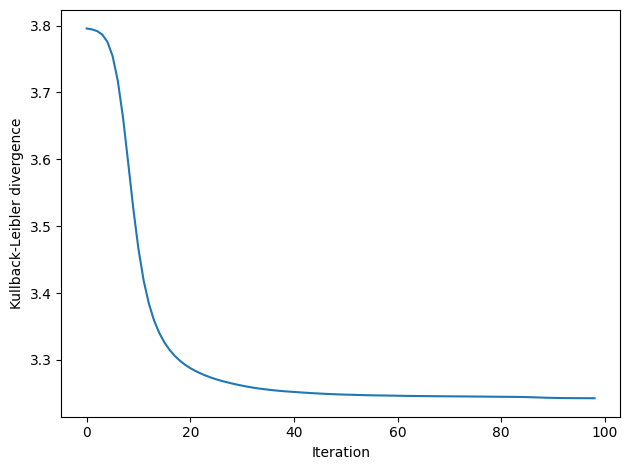

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
_ = visualize.convergence(ax)
fig.tight_layout()

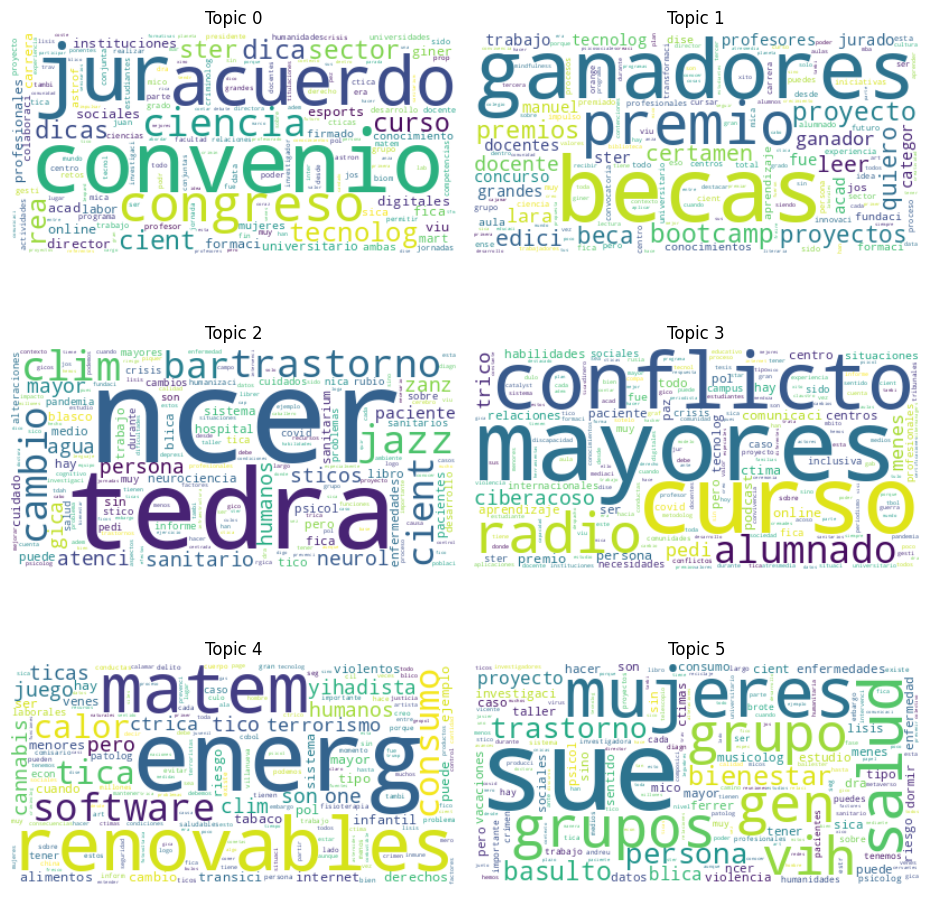

In [ ]:
fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)